In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


In [1]:
import sys 
# sys.path.clear()
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\python36.zip')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\DLLs')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib\\site-packages')
sys.path.insert(0, '')

In [2]:
import sys
sys.path

['/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python36.zip',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/lib-dynload',
 '',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/extensions',
 '/Users/litos/.ipython']

sys.path = ['', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python36.zip', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/lib-dynload', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages']

In [3]:
from gurobipy import *

In [35]:
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize
from collections import *
import datetime
import json
import pandas as pd
import time
# import yaml
import scipy.sparse as sparse
from ast import literal_eval

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.utils.extmath import randomized_svd

from scipy.optimize import minimize

# Load Data

In [5]:
# Load Original Data
df_train = pd.read_csv('../../data/yelp/Train.csv',encoding='latin-1')
# df_valid = pd.read_csv('../../data/yelp/Valid.csv',encoding='latin-1')
# df_test = pd.read_csv('../../data/yelp/Test.csv',encoding='latin-1')

In [6]:
keyphrases = pd.read_csv('../../data/yelp/KeyPhrases.csv')['Phrases'].tolist()
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

# Load U-I Data 
rtrain = load_npz("../../data/yelp/Rtrain.npz")
rvalid = load_npz("../../data/yelp/Rvalid.npz")
rtest = load_npz("../../data/yelp/Rtest.npz")

# Load user/item keyphrase data
U_K = load_npz("../../data/yelp/U_K.npz")
I_K = load_npz("../../data/yelp/I_K.npz")

# Models

In [7]:
# Models
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, row_name = 'ItemIndex', shape = (3668,75)):
    rows = []
    cols = []
    vals = []
    for i in tqdm(range(df.shape[0])):
        key_vector = literal_eval(df['keyVector'][i])
        rows.extend([df[row_name][i]]*len(key_vector)) ## Item index
        cols.extend(key_vector) ## Keyword Index
        vals.extend(np.array([1]*len(key_vector)))
    return csr_matrix((vals, (rows, cols)), shape=shape)



def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    for user_index in tqdm(range(matrix_Train.shape[0])):
        vector_u = prediction_score[user_index]
        vector_train = matrix_Train[user_index]
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)


def sub_routine(vector_u, vector_train, topK=500):

    train_index = vector_train.nonzero()[1]

    vector_u = vector_u

    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    return vector_u[:topK]


In [8]:
def predict(matrix_train, k, similarity, item_similarity_en = False):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    """
    prediction_scores = []
    
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores to all users
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        similar_users = vector_u.argsort()[::-1][1:k+1]
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        similar_users_ratings = matrix_train[similar_users].toarray()

        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]

        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    
    return res

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

In [9]:
# PLREC 
def inhour(elapsed):
    return time.strftime('%H:%M:%S', time.gmtime(elapsed))

def plrec(matrix_train, iteration=4, lamb=80, rank=200, seed=1):
    """
    Function used to achieve generalized projected lrec w/o item-attribute embedding
    :param matrix_train: user-item matrix with shape m*n
    :param iteration: number of power iterations in randomized svd
    :param lamb: parameter of penalty
    :param rank: latent dimension size
    :param seed: the seed of the pseudo random number generator to use when shuffling the data
    :return: prediction in sparse matrix
    """
    print ("Randomized SVD")
    start_time = time.time()
    P, sigma, Qt = randomized_svd(matrix_train,
                                  n_components=rank,
                                  n_iter=iteration,
                                  random_state=seed)

    RQ = matrix_train.dot(sparse.csc_matrix(Qt.T*np.sqrt(sigma)))

    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    print ("Closed-Form Linear Optimization")
    start_time = time.time()
    pre_inv = RQ.T.dot(RQ) + lamb * sparse.identity(rank, dtype=np.float32)
    inverse = sparse.linalg.inv(pre_inv.tocsc())
    Y = inverse.dot(RQ.T).dot(matrix_train)
    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    return np.array(RQ.todense()), np.array(Y.todense()), None

def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items

    
    
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


# Evaluation

In [10]:
# Evluation 
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)

def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        "R-Precision": r_precision,
        "NDCG": ndcg,
        "Clicks": click
    }

    local_metrics = {
        "Precision": precisionk,
        "Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))

        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = results[name]
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (np.average(results[name]),
                                                              1.96*np.std(results[name])/np.sqrt(num_users))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))

    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = results[name]
    else:
        for name in global_metric_names:
            results_summary[name] = (np.average(results[name]), 1.96*np.std(results[name])/np.sqrt(num_users))
    output.update(results_summary)

    return output



## Single Step Critiquing Pipline

### Initial Prediction

In [11]:
# KNN initial Prediction
def get_initial_prediction(user,X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    """
    Get the initial knn predictions before critiquing pipelines
    get the linear regression model for critiquing embedding (W_2)
    get the initial user similarity matrix 
    k here is the parameter for KNN
    """
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict_vector(user, matrix_Train, k, similarity)
    return user_item_prediction_score, clf


In [12]:
# PLREC initial Prediction
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


### Forward predict

Predict a single row (for single user)

In [13]:
# KNN

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

def predict_vector(user_index, matrix_train, k, similarity, with_keyphrase = False, 
                   keyphrase_freq = None, critiqued_keyphrase = None, alpha = 0):
    """
    get only user_index row
    if with_keyphrase = True, then penalize items without critiqued_keyphrase to alpha (default = 0)
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    if with_keyphrase == False:
        return np.sum(prediction_scores_u, axis=0)
    
    # Only Predict items with critiqued_keyphrase 
    else:
        prediction_scores = np.sum(prediction_scores_u, axis=0)
#         print (prediction_scores)
        #penalize items without critiqued keyphrase
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
#         print (items_with_keyphrase)
        #Return the unique values in ar1 that are not in ar2.
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_train.shape[1]), items_with_keyphrase)
        prediction_scores[items_without_keyphrase] = alpha # penalize
        return prediction_scores
#         print (prediction_scores)
#         return prediction_scores/sum(prediction_scores)


In [14]:
# PLREC
def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items


### Keyphrase Selection

In [15]:
def get_valid_keyphrases(keyphrase_freq,top_recommendations,item = None,threshold=50,mutiple_keyphrases_en = False, top_items = None):
    """
    Wrapper function to get either top 1 or top n keyphrases
    """
    if mutiple_keyphrases_en:
        top_keyphrases = []
        for item in top_items:
            top_keyphrases.extend(get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold))
        return np.ravel(list(set(top_keyphrases))) # remove duplicate and reformat to np array
    else:
        return get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold)

def get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations, item,threshold=50):
    """
    Get keyphrases of item that make sense
    E.g. if the item has fewer than threshold=50 keyphrases, get all of them
    otherwise get top 50 keyphrases
    """
    keyphrase_length = len(keyphrase_freq[item].nonzero()[1])
    if keyphrase_length<threshold:
        return keyphrase_freq[item].nonzero()[1]
    else:
        keyphrases = np.ravel(keyphrase_freq[top_recommendations[0]].todense())
        top_keyphrases = np.argsort(keyphrases)[::-1][:threshold]
        return top_keyphrases
    
# For keyphrase selecting method # 3 "diff" 
def get_item_keyphrase_freq(keyphrase_freq,item):
    """
    Get item's keyphrase frequency 
    """
    count = keyphrase_freq[item].todense()
    return count/np.sum(count)

def get_keyphrase_popularity(df,keyphrases):
    """
    Get keyphrase popularity (count) from dataframe
    """
    keyphrase_popularity = np.zeros(len(keyphrases)) #initialize
    for i in range(len(df)):
        keyphrase_vector = literal_eval(df['keyVector'][i])
        keyphrase_popularity[keyphrase_vector] += 1 # count
    return keyphrase_popularity

### Critiquing Methods

In [16]:
# One hot encoding of critiquing
def get_critiqued_UK(user_keyphrase_frequency,user_index,critiqued_keyphrase):
    """
    user_keyphrase_frequency is the U_K matrix (csr sparse matrix)
    return the one-hot encoding of the critique
    """
    U_K_cp = user_keyphrase_frequency.copy()
    U_K_cp[user_index] = 0
    U_K_cp[user_index,critiqued_keyphrase] = 1
    return U_K_cp

def project_one_hot_encoding(reg, user_keyphrase_frequency,user_index = 0,critiqued_keyphrase = 0, normalize_en = True):
    """
    Return the projection on user_sim space from one-hot encoding of critiqued keyphrase
    The res[user_index] should be target embedding row
    """
    critiqued_matrix = get_critiqued_UK(user_keyphrase_frequency, user_index, critiqued_keyphrase)
    res = reg.predict(critiqued_matrix)
    if normalize_en:
        res = normalize((res))
    return res

In [17]:
# Upper bound method 
def get_all_affected_items(wanted_keyphrases,keyphrase_freq):
    res = []
    for keyphrase in wanted_keyphrases:
        items = np.ravel(keyphrase_freq.T[keyphrase].nonzero()[1])
        res.extend(items)
    return np.array(list(set(res)))
    
def select_only_wanted_keyphrase(top_recommendations, wanted_keyphrases, keyphrase_freq, matrix_Train = rtrain):
    all_items_with_keyphrases = get_all_affected_items(wanted_keyphrases,keyphrase_freq)
    affected_items = np.setdiff1d(np.arange(matrix_Train.shape[1]), all_items_with_keyphrases) # Get all other keyphrases
    top_recommendations[~np.in1d(top_recommendations, affected_items)]
    return top_recommendations

def pruning(prediction_score, 
           wanted_keyphrases_random, 
           top_recommendations, 
           keyphrase_freq, 
           matrix_Train = rtrain,
           alpha = 0):
    items_with_keyphrase = get_all_affected_items(wanted_keyphrases_random, keyphrase_freq)
    #Return the unique values in ar1 that are not in ar2.
    items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
#     print (items_without_keyphrase)
    print (sum(prediction_score[items_without_keyphrase]))
    score = np.copy(prediction_score)
    score[items_without_keyphrase] = alpha # penalize
    return score

### Utilities

In [18]:
# Utility function for getting restaurant info from ItemIndex
def get_business_df(path = "../../data/yelp/business.json" ):
    with open(path,encoding="utf8") as json_file:
        data = json_file.readlines()
        data = list(map(json.loads, data))
    df = pd.DataFrame(data)
    
    return df

def get_restaurant_info(business_df, business_id, name = True, review_count = True, stars = True ):
    output_list = {}
    row_idx = int(business_df.index[business_df['business_id'] == business_id].tolist()[0])
    if name == True:
        output_list['name'] = business_df['name'][row_idx].encode('utf-8').strip()
    if review_count == True:
        output_list['review_count'] = business_df['review_count'][row_idx]
    if stars == True:
        output_list['stars'] = business_df['stars'][row_idx] 
    return output_list

# def get_businessid_from_Itemindex(ItemIndex_list, itemindex):
#     return ItemIndex_list['business_id'].tolist()[itemindex]

def get_restaurant_name(df_train, business_df, ItemIndex):
    rows = np.where(df_train['ItemIndex'] == ItemIndex)
    if len(rows)!= 0:
        business_id = df_train.loc[rows[0][0]]['business_id']
        item_info = get_restaurant_info(business_df, business_id)
        return item_info['name']
    return "NOT_FOUND"

### Experiment Function

In [19]:
business_df = get_business_df()

In [20]:
Y, RQt, Bias = plrec(rtrain,
                    iteration = 10,
                    lamb = 200,
                    rank = 200)
RQ = RQt.T
reg = LinearRegression().fit(normalize(U_K), Y)

Randomized SVD
Elapsed: 00:00:00
Closed-Form Linear Optimization
Elapsed: 00:00:00


In [21]:
# Set up dataframe 

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 

columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'random_scores',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'pop_scores',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'diff_scores',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

In [22]:
def single_step_critiquing_plrec(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity, 
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                           reg = reg, Y = Y, RQt = RQt, Bias = Bias,
                           top_k_rec = 20, affected_weight = 1, unaffected_weight = -1
                          ):
    """
    k: HR@k 
    keyphrase_length_threshold: limit the number of keyphrases in top recommended item
    keyphrase_selection_method: 'random': randomly select keyphrase from wanted_keyphrases
                                'pop': always select the most popular keyphrase in wanted_keyphrases
                                'diff': select the keyphrase with largest frequency difference between top recommended 
                                        item and target item.
    recommend_type: 'all': recommend all items
                    'upper' (only_with_critiqued_keyphrase): recommend items with only critiqued_keyphrase
    lam: modified_matrix = lam*origianl_matrix + (1-lam)*critiquing_embedding 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    
    # Set up (move to header line later)
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    num_items = rtrain.shape[1]
    max_wanted_keyphrase = 10 # for keyphrase_selection_method == "diff"
    initial_user_similarity_embedding = normalize(train(matrix_Train))
    
    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items length: ',len(wanted_items))
    
    # Get initial forward prediction 
    prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
    
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation index",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    except: 
        row['top_prediction_item_name'] = 'CANNOT_FIND'
        print ('Cannot get restaurant name for ItemIndex: ', top_recommendations[0])
    
    
    # Get top recommended item's keyphrases
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,
                                                    top_recommendations, 
                                                    item = top_item,
                                                    threshold=keyphrase_length_threshold,
                                                    mutiple_keyphrases_en = False, 
                                                    top_items = None)
    top_recommended_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = top_item)
    
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0 # initialize item count
    
    for item in wanted_items:    
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            row['item_name'] = 'CANNOT_FIND'
            print ('Cannot get restaurant name for ItemIndex: ', item)

        # Get pre-critiquing rank
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
        
        # For diff 
        target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
        diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
        
        wanted_keyphrases_random = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_pop = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_diff = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
        
        pruned_prediction_score = pruning(prediction_score, 
                                           wanted_keyphrases_random, 
                                           top_recommendations, 
                                           keyphrase_freq, 
                                           matrix_Train = rtrain)
        pure_pruning_rank = np.where(item == np.argsort(pruned_prediction_score)[::-1])[0][0]
        if pure_pruning_rank>initial_rank:
            pure_pruning_rank = initial_rank
        row['pure_pruning_rank'] = int(pure_pruning_rank)    
        
        affected_items = np.array([])
        modified_matrix = initial_user_similarity_embedding # initialize user similarity embedding
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            row['iter'] = iteration

            if len(wanted_keyphrases_random) == 0 or len(wanted_keyphrases_diff) == 0: 
                print ('no more keyphrase available')
                break
            critiqued_keyphrase_random = np.random.choice(wanted_keyphrases_random, size=1, replace=False)[0]
            critiqued_keyphrase_pop = wanted_keyphrases_pop[np.argmin(keyphrase_popularity[wanted_keyphrases_pop])] # Select the least popular
            critiqued_keyphrase_diff = wanted_keyphrases_diff[0]
            
            row['critiqued_keyphrase_random'] = critiqued_keyphrase_random
            row['keyphrase_name_random'] = keyphrases[critiqued_keyphrase_random]
            row['critiqued_keyphrase_pop'] = critiqued_keyphrase_pop
            row['keyphrase_name_pop'] = keyphrases[critiqued_keyphrase_pop]
            row['critiqued_keyphrase_diff'] = critiqued_keyphrase_diff
            row['keyphrase_name_diff'] = keyphrases[critiqued_keyphrase_diff]
            
            # Do not critique this keyphrase next time
            wanted_keyphrases_random = np.delete(wanted_keyphrases_random, np.where(critiqued_keyphrase_random == wanted_keyphrases_random))
            wanted_keyphrases_pop = np.delete(wanted_keyphrases_pop, np.where(critiqued_keyphrase_pop == wanted_keyphrases_pop))
            wanted_keyphrases_diff = np.delete(wanted_keyphrases_diff, np.where(critiqued_keyphrase_diff == wanted_keyphrases_diff))
            
            # Critiquing Embedding

            # One hot encoding
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_random =critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_pop)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_pop = critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_diff)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_diff = critiqued_matrix


            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            post_ranks_random_all = []
            post_ranks_random_upper = []
            random_scores = []
            post_ranks_pop_all = []
            post_ranks_pop_upper = []
            pop_scores = []
            post_ranks_diff_all = []
            post_ranks_diff_upper = []
            diff_scores = []
            
            num_items = matrix_Train.shape[1]
            affected_items_random = keyphrase_freq[:,critiqued_keyphrase_random].nonzero()[0]
            affected_items_pop = keyphrase_freq[:,critiqued_keyphrase_pop].nonzero()[0]
            affected_items_diff = keyphrase_freq[:,critiqued_keyphrase_diff].nonzero()[0]
            unaffected_items_random = np.setdiff1d(range(num_items), affected_items_random)
            unaffected_items_pop = np.setdiff1d(range(num_items), affected_items_pop)
            unaffected_items_diff = np.setdiff1d(range(num_items), affected_items_diff)
            
            for lam in lams:
                modified_matrix_random = (1-lam)*Y + lam*critiqued_matrix_random 
                modified_matrix_pop = (1-lam)*Y + lam*critiqued_matrix_pop 
                modified_matrix_diff = (1-lam)*Y + lam*critiqued_matrix_diff 
                
                # Random
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_all.append(item_rank)
                
                # Random scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_random))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_random))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                random_scores.append(score)
                
                # Random upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_random, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_upper.append(item_rank)
                
                # Pop
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_all.append(item_rank)
                
                
                # pop scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_pop))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_pop))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                pop_scores.append(score)
                
                # Pop upper 
                
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_pop, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_upper.append(item_rank)
                
                # Diff
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_all.append(item_rank)
                
                # Diff scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_diff))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_diff))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                diff_scores.append(score)
                
                # Diff upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_diff, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_upper.append(item_rank)
                
                
            row['post_rank_random_all'] = post_ranks_random_all
            row['post_rank_random_upper'] = post_ranks_random_upper
            row['random_scores'] = random_scores
            row['post_rank_pop_all'] = post_ranks_pop_all
            row['post_rank_pop_upper'] = post_ranks_pop_upper
            row['pop_scores'] = pop_scores
            row['post_rank_diff_all'] = post_ranks_diff_all
            row['post_rank_diff_upper'] = post_ranks_diff_upper
            row['diff_scores'] = diff_scores
            df = df.append(row, ignore_index=True)
            

        # break after got 10 target items 
        num_target_item += 1
        if num_target_item >10: # only want max 10 items per user
            break
            
    return df

In [23]:
single_step_with_avg_path = '../tables/critiquing/plrec_with_obj/'

In [46]:
# PLREC
columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

#only_with_critiqued_keyphrase
for user in range(300,350):
    df = single_step_critiquing_plrec(user = user, 
                           keyphrase_length_threshold = 230, 
                           max_iteration_threshold = 10,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity,
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           top_k_rec=40
                           )
df.to_csv(single_step_with_avg_path+"ranking_and_rating_test.csv")

User ID  300
wanted_items length:  14
Initial top recommendation index 5010
target_item:  101
41.54450767803064
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  886
17.15063242740507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  968
16.475838166974427
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1620
140.5959442619278
cur_iter  0
no more keyphrase available
target_item:  1898
10.686718769607978
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2803
11.871685572277784
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3822
131.28218291769008
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4025
44.43994439533708
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  4906
28.516939810702752
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5041
11.519445263089438
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5098
8.70336792814851
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  301
wanted_items length:  0
Initial top recommendation index 7455
User ID  302
wanted_items length:  7
Initial top recommendation index 2804
target_item:  1833
115.29525302378534
cur_iter  0
no more keyphrase available
target_item:  2286
21.13192866949612
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2810
40.393916500204796
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4091
30.837863495446072
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4216
21.71423218932614
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4499
23.53944493585368
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5040
18.724573726161907
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  303
wanted_items length:  7
Initial top recommendation index 1406
target_item:  38
8.093505860144433
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1199
9.765815448432477
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3368
8.21222663304934
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4432
17.631019831282856
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  5659
5.192670696333153
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6023
10.36828398755415
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6990
10.106438368605723
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  304
wanted_items length:  10
Initial top recommendation index 6454
target_item:  1483
55.639043799475076
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1985
32.2618766240339
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  3158
68.55869760168298
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  4323
2.3940936588478507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5081
1.0545628861691512
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5710
123.45319507330441
cur_iter  0
no more keyphrase available
target_item:  6222
13.676836167596775
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6323
16.192818702566
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6708
16.492949171883083
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7163
3.2621703870318015
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  305
wanted_items length:  15
Initial top recommendation index 3377
target_item:  39
6.28778319957928
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1890
24.091780765886142
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1985
7.123054937228517
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2589
8.522378457637387
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2780
16.44211614359847
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3598
11.081918920339376
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3850
14.022928320418941
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4238
12.258416679660513
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4299
54.64380187390816
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  4772
8.740459875494707
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5364
5.7202746126586135
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  306
wanted_items length:  9
Initial top recommendation index 5410
target_item:  647
21.557759184200904
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1340
10.454419865753835
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
13.096237904399231
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1562
10.639681713839309
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2039
13.824247260419725
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3554
9.817353331041886
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6454
8.652911561390283
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6772
17.086175616650507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7286
10.110714223674222
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  307
wanted_items length:  5
Initial top recommendation index 5659
target_item:  1392
42.83638768234596
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  2517
58.425356291374555
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  2841
19.239740810713556
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5147
74.88214341306048
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5280
28.661173629632685
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
User ID  308
wanted_items length:  25
Initial top recommendation index 5363
target_item:  213
88.89424569472112
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  467
37.03649839752552
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  545
103.59029356193287
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  637
39.190079759679065
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  867
105.19793699112279
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  870
23.84333159239395
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1244
36.45351960503103
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1608
23.83167016189327
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1784
55.95916726899668
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  2055
22.353767205753684
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2089
Cannot get restaurant name for ItemIndex:  2089
60.57288503902464
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
User ID  309
wanted_items length:  13
Initial top recommendation index 1652
target_item:  179
20.426827677629262
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  754
7.659004584595095
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2038
11.065235780220974
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3114
44.02543922961377
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3139
10.253860624647132
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3247
15.957386880047125
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4072
8.912003458963227
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4707
10.64231486827157
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4828
14.520350007960587
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5377
9.660384956327107
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5471
32.35336940640809
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
User ID  310
wanted_items length:  8
Initial top recommendation index 2446
target_item:  425
96.03763066108718
cur_iter  0
no more keyphrase available
target_item:  754
4.520565126618749
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3072
17.668003073840737
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3964
14.871009393229542
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  4582
12.441912505859591
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4799
11.573035209115915
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7100
3.570004828654419
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7445
23.07169950251614
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
User ID  311
wanted_items length:  6
Initial top recommendation index 3997
target_item:  279
3.69326971159353
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2089
Cannot get restaurant name for ItemIndex:  2089
4.728034570633099
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3229
3.4945797231575852
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6437
4.422368473936331
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6735
3.744158851103748
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7427
3.318152206634295
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  312
wanted_items length:  9
Initial top recommendation index 6454
target_item:  75
14.670182154133727
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  299
11.11814121147654
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2341
6.331159969913642
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3718
6.705197324579785
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5144
14.395450766509384
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  5402
8.164501424968194
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5784
8.433530338583296
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6508
22.528001588514826
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6739
8.339587744141681
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  313
wanted_items length:  6
Initial top recommendation index 6688
target_item:  957
29.79575613864381
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  1392
7.005471110488088
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1548
3.084778967612692
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4952
5.310037241206828
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5478
6.59125299701418
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6717
4.64915414866573
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  314
wanted_items length:  36
Initial top recommendation index 3377
target_item:  20
17.416210611802853
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  42
Cannot get restaurant name for ItemIndex:  42


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


454.23964947815057
cur_iter  0
no more keyphrase available
target_item:  53
39.15758283811101
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  84
14.081707121936233
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  774
9.658837687057712
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  818
14.588304458550738
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  868
25.45710843991492
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  991
454.23964947815057
cur_iter  0
no more keyphrase available
target_item:  1063
14.983840600108124
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1726
20.160409943776358
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1858
12.345332956211678
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  315
wanted_items length:  12
Initial top recommendation index 5659
target_item:  488
59.324265322112296
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1202
77.69497656517615
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1218
35.16940868881193
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  2729
20.050708165458673
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3040
45.709226514381044
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  4034
30.353928087058193
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5820
37.96124102363137
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6243
50.69140190762391
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  6258
26.887229852404744
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6437
35.13769839606266
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7037
66.13069384285973
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
User ID  316
wanted_items length:  7
Initial top recommendation index 3347
target_item:  463
13.727132054901176
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  914
23.344327047436764
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1700
15.113677684165395
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2667
12.774674745200628
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4442
10.704753505543067
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5485
9.161848062176887
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5852
13.616757290754776
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  317
wanted_items length:  37
Initial top recommendation index 419
target_item:  278
30.811917497131617
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  612
77.58287549949728
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  711
121.30676118465726
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1249
23.702677916148787
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1291
28.998596120533875
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1308
39.48985959517722
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1445
24.715684403427986
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1782
47.28297025475604
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1784
37.3809689511063
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1864
99.28751508786354
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1978
146.4652453791723
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
User ID  318
wanted_items length:  5
Initial top recommendation index 4762
target_item:  1528
9.017085440927985
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4115
61.59169163073011
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5493
51.97182234020465
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6268
6.633201158262182
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6617


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


68.40659091088446
cur_iter  0
no more keyphrase available
User ID  319
wanted_items length:  7
Initial top recommendation index 5286
target_item:  39
8.549212264357266
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2401
41.98999464612734
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  2641
24.594848950070627
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  3182
11.782398340163127
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3895
22.342214749371124
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  6320
58.29076277162403
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  6454
5.2923106212792845
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  320
wanted_items length:  7
Initial top recommendation index 5081
target_item:  68
3.5275838226034466
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1288
2.7659297262416658
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3083
2.4688391124527698
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3333
3.0817781553141685
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4072
3.374489015868676
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
2.2791840517547826
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5577
2.3376743406297464
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  321
wanted_items length:  24
Initial top recommendation index 6454
target_item:  174
33.4622726039961
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  201
17.10717293494963
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  910
48.31708066189458
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  1361
22.54133091896074
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1378
19.210014884651173
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
31.435894141803146
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1652
26.12626371208171
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1807
47.41046888483106
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2243
32.169868973585835
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2537
42.4132701837043
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3333
20.695202854272793
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  322
wanted_items length:  18
Initial top recommendation index 43
target_item:  1250
45.00917631345328
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  2147
57.73829915045826
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2446
14.07008168183711
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2449
22.070690071917852
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2942
20.174814130246887
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3301
51.93874159439474
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3333
16.068718160744538
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3377
26.850064493048194
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3558
77.83762546935941
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4495
16.37379479275296
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5081
22.415069339929687
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  323
wanted_items length:  7
Initial top recommendation index 3997
target_item:  161
3.3512202443916976
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1218
6.581460685588354
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1490
3.8078857661093934
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4383
25.218179115451676
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  4421
4.339086238755954
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5637
90.94476714955726
cur_iter  0
no more keyphrase available
target_item:  6555
5.754812209510419
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  324
wanted_items length:  25
Initial top recommendation index 4443
target_item:  533
57.84027231740765
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  635
71.889970024371
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  766
118.05594918290444
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  854
79.07636843757791
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1209
55.445754034757556
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1337
147.9646187273902
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  1474
280.90689680577634
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  2031
52.94250177004142
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2509
97.83647506498528
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2894
54.87213874261943
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2923
236.80204039495584
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
User ID  325
wanted_items length:  8
Initial top recommendation index 4972
target_item:  1463
33.012809720832706
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1567
30.984612303334984
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  2794
11.621598765823933
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2957
7.229773198648218
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4141
6.536370588247792
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6071
16.935405753821215
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7195
11.069311177132022
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7425
10.299651991722385
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  326
wanted_items length:  13
Initial top recommendation index 5410
target_item:  36
5.603118195831485
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  828
10.84730287353159
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1219
8.153617194358958
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1411
16.595520323011442
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1467
12.470883081026841
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1780
30.100888469765778
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3264
13.905563450847694
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  3743
24.793590341192612
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3771
8.090019588235009
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4554
21.96198870724038
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4673
8.562274900024931
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  327
wanted_items length:  8
Initial top recommendation index 6668
target_item:  95
Cannot get restaurant name for ItemIndex:  95


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


116.30833311879633
cur_iter  0
no more keyphrase available
target_item:  1044
15.46147513838514
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1644
14.564457879754627
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1955
9.257163756490627
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2889
10.517596935271285
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3339
44.58751413782602
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  5118
7.448677393034814
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7070
10.345717244116258
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  328
wanted_items length:  8
Initial top recommendation index 4443
target_item:  3401
17.39641975730774
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  4011
12.384185321378027
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4820
11.490794900557376
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6167
8.627727742399657
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6288
23.53299924264502
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6864
14.565477080956043
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  6950
Cannot get restaurant name for ItemIndex:  6950


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


119.28915449399574
cur_iter  0
no more keyphrase available
target_item:  6958
8.694130947238591
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  329
wanted_items length:  14
Initial top recommendation index 6739
target_item:  790
11.657252141591016
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1107
11.383940249532316
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1259
9.256586665334908
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1658
18.47062210391232
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2436
70.0344870897261
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  2643
48.66911045629968
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2653
36.78532954112961
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  2699
69.65716652420997
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  4332
20.881771955489967
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4428
9.056939679703646
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4939
10.094633115480974
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  330
wanted_items length:  5
Initial top recommendation index 201
target_item:  1187
6.199841367198587
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1898
7.455229607679485
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3149
5.407471556290602
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3185
7.675009369615509
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4831
15.085698071417937
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  331
wanted_items length:  5
Initial top recommendation index 5852
target_item:  3279
9.284386301826089
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4713
34.50680308139226
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5033
3.457781318812522
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5850
11.167739660005282
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7199
10.351160435327984
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  332
wanted_items length:  0
Initial top recommendation index 7455
User ID  333
wanted_items length:  20
Initial top recommendation index 6222
target_item:  570
7.371595370426803
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  790
7.049107267597719
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1268
10.954568646164262
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1863
8.389025059354026
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1887
22.50692542543402
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2299
7.43890419145464
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2898
7.387350683613477
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3064
13.846205820926116
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3417
13.08251386351185
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3428
5.802086874071392
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3585
16.8153845967463
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  334
wanted_items length:  8
Initial top recommendation index 4443
target_item:  276
1.9383252703742073
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  535
2.9771960269649753
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3416
7.007151242677082
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3499
1.5842739731201618
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3646
2.4259717385889417
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3700
2.7889782859697334
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5972
3.2414727426698846
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7090
31.265193468345387
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
User ID  335
wanted_items length:  9
Initial top recommendation index 3772
target_item:  2013
6.379761045614828
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2573
2.2179468252469405
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3983
3.9504496022454987
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
2.61582894478488
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4683
4.182686355787155
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6068
31.064527600905308
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6302
92.2462516989466
cur_iter  0
no more keyphrase available
target_item:  6815
8.525645816893643
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7303
8.127281518092673
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  336
wanted_items length:  5
Initial top recommendation index 6498
target_item:  593
14.910754313731104
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  3198
15.778408250311713
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  3337
3.831325997991371
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6149
9.681149757579533
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  6811
6.697612468691659
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  337
wanted_items length:  7
Initial top recommendation index 39
target_item:  533
3.2696969733142396
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1043
8.256168857682496
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2964
7.560744827995222
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3185
1.932391399426706
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3748
1.5228518085386895
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5080
3.8943133187649437
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5288
2.1986914007047744
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  338
wanted_items length:  11
Initial top recommendation index 2729
target_item:  1438
13.00260535794041
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2812
8.843413227291109
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3259
12.245280783424732
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3717
15.32738866522186
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4423
9.54444131687842
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5315
5.719723903753675
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5659
4.936712384156181
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6454
5.220482814625939
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6776
8.138656753819305
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6975
8.599062066082752
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7205
8.940809596378585
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  339
wanted_items length:  7
Initial top recommendation index 7100
target_item:  38
25.293083702783406
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2630
101.38105195156868
cur_iter  0
no more keyphrase available
target_item:  3477
25.732562975339988
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  3758
41.556183703156876
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  4442
28.42638132142929
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5424
70.21601352431799
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6681
20.052030687651495
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  340
wanted_items length:  4
Initial top recommendation index 2804
target_item:  2489
12.263708542969425
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4417
14.459417314399161
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  5626
5.820064100887976
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6644
5.316535479512822
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  341
wanted_items length:  27
Initial top recommendation index 5081
target_item:  43
4.248640084253566
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  68
8.289863504232017
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  407
14.93244436083478
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  673
4.61680146423987
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  934
8.868559421543068
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1244
9.552486934291665
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1777
5.012241134058058
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2400
7.365855893876869
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2569
6.373300176456723
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2812
12.415025973072261
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3044
5.176004570967962
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  342
wanted_items length:  5
Initial top recommendation index 7137
target_item:  1057
5.763608593434583
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5041
2.7540277292173414
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5208
14.560438511743996
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  6509
Cannot get restaurant name for ItemIndex:  6509


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


62.20142586699092
cur_iter  0
no more keyphrase available
target_item:  7304
62.20142586699092
cur_iter  0
no more keyphrase available
User ID  343
wanted_items length:  49
Initial top recommendation index 6167
target_item:  84
57.86126381097233
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  108
127.91958560446324
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  735
44.882011285932776
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  935
32.1978502884092
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  955
57.03537560384643
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1472
71.96619129752139
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1652
28.518935270877364
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1665
145.88702716913645
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1710
106.63403322858244
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  2564
65.70772866661059
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2696
80.22293046496156
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  344
wanted_items length:  41
Initial top recommendation index 4786
target_item:  116
339.50964417297655
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  201
17.1789593476351
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  327
41.50873886701447
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  530
32.296315203049744
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1246
38.78807938715181
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1478
41.448079135057924
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
31.45959324195428
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1689
32.92438605076313
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1761
37.89355831429566
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1776
78.0746804022856
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1832
23.63271454070491
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  345
wanted_items length:  8
Initial top recommendation index 6299
target_item:  495
21.913122513412418
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  601
7.664101013019717
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2687
24.718403623989616
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  2788
7.962339771424922
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2847
7.3746326356713325
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3211
7.45410994535996
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4566
7.894092172760793
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7313
5.68710525626193
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  346
wanted_items length:  11
Initial top recommendation index 6776
target_item:  17
10.482377745140184
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  416
11.62667292525839
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1204
6.535947868676885
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3590
10.944103361840462
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3883
6.9156894537154585
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3958
28.27724381330154
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4788
9.581881199437703
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5010
6.229080880713809
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5410
7.246435473414749
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5538
18.474784559590262
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5773
74.94007055407383
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
User ID  347
wanted_items length:  49
Initial top recommendation index 2514
target_item:  476
46.8458319600968
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  566
39.897555286367606
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  612
63.22920840338065
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  935
29.98317638122262
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  973
41.362226945185284
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1311
120.45250828826738
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1438
36.988595421452374
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1643
60.795600330163325
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1898
39.759632550599235
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2006
29.8807231012006
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2313
36.14095972040104
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  348
wanted_items length:  5
Initial top recommendation index 2804
target_item:  149
22.565958432555362
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  823
9.838339096917025
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2791
7.8183959352340935
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3933
8.702800315210425
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6858
7.8810880984342475
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  349
wanted_items length:  8
Initial top recommendation index 2154
target_item:  265
4.498716580348173
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1357
3.94483704831282
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1621
76.47046768302346
cur_iter  0
no more keyphrase available
target_item:  2855
2.5992250663816776
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3865
3.502272245460972
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4148
3.6138504591203855
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
3.7859466631548457
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6210
5.580482321810905
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9


In [47]:
df

,user_id,target_item,item_name,iter,pre_rank,top_prediction_item_name,post_rank_random_all,post_rank_random_upper,post_rank_pop_all,post_rank_pop_upper,...,keyphrase_name_random,critiqued_keyphrase_pop,keyphrase_name_pop,critiqued_keyphrase_diff,keyphrase_name_diff,num_existing_keyphrases,pure_pruning_rank,diff_scores,pop_scores,random_scores
0,300,101,b'Cabin Fever',0,4830,b'Sansotei Ramen',"[4830, 4739, 4610, 4486, 4284, 3670, 3412, 316...","[6831, 6828, 6810, 6804, 6781, 903, 872, 841, ...","[4830, 4870, 4919, 4942, 4934, 4890, 4815, 468...","[7062, 7062, 7064, 7074, 7079, 7070, 7047, 702...",...,latte,155,refill,53,tea,NaN,4830,"[40, 40, 38, 38, 38, 40, 40, 40, 40, 40, 40]","[-12, -8, -8, -6, -6, 0, 2, 10, 8, 6, 6]","[14, 12, 12, 12, 14, 16, 18, 16, 20, 22, 22]"
1,300,101,b'Cabin Fever',1,4830,b'Sansotei Ramen',"[4830, 4870, 4919, 4942, 4934, 4890, 4815, 468...","[7062, 7062, 7064, 7074, 7079, 7070, 7047, 702...","[4830, 4739, 4610, 4486, 4284, 3670, 3412, 316...","[6831, 6828, 6810, 6804, 6781, 903, 872, 841, ...",...,refill,105,latte,153,friendly,NaN,4830,"[40, 40, 40, 40, 40, 40, 40, 40, 40, 38, 38]","[14, 12, 12, 12, 14, 16, 18, 16, 20, 22, 22]","[-12, -8, -8, -6, -6, 0, 2, 10, 8, 6, 6]"
2,300,101,b'Cabin Fever',2,4830,b'Sansotei Ramen',"[4830, 4720, 4589, 4394, 3757, 3473, 3180, 286...","[6685, 6671, 6655, 6630, 1151, 1109, 1060, 100...","[4830, 4720, 4589, 4394, 3757, 3473, 3180, 286...","[6685, 6671, 6655, 6630, 1151, 1109, 1060, 100...",...,bread,37,bread,105,latte,NaN,4830,"[14, 12, 12, 12, 14, 16, 18, 16, 20, 22, 22]","[12, 12, 14, 12, 14, 18, 20, 18, 18, 24, 24]","[12, 12, 14, 12, 14, 18, 20, 18, 18, 24, 24]"
3,300,886,b'Wok & Roast Chinese BBQ',0,3515,b'Sansotei Ramen',"[3515, 4187, 4557, 4934, 5270, 5442, 5503, 554...","[563, 7021, 7067, 7107, 7136, 7137, 7135, 7141...","[3515, 2877, 2365, 2086, 1917, 1813, 1747, 171...","[26, 29, 31, 30, 30, 31, 32, 33, 33, 33, 32]",...,toast,223,general tao,27,bbq,NaN,2442,"[-10, -12, -10, -10, -10, -2, -2, -4, 0, 4, 6]","[-40, -40, -40, -38, -36, -34, -34, -34, -34, ...","[4, 0, 4, 12, 14, 14, 10, 14, 16, 16, 16]"
4,300,886,b'Wok & Roast Chinese BBQ',1,3515,b'Sansotei Ramen',"[3515, 4422, 5016, 5376, 5627, 5740, 5802, 580...","[267, 7254, 7271, 7277, 7297, 7305, 7308, 7305...","[3515, 2822, 2360, 2019, 1796, 1669, 1590, 151...","[108, 115, 124, 128, 125, 123, 121, 118, 121, ...",...,squid,73,congee,0,chinese,NaN,2442,"[-8, -4, -2, 4, 8, 16, 24, 24, 30, 30, 30]","[-28, -30, -22, -18, -12, -12, -8, -10, -10, -...","[-20, -22, -18, -14, -10, -6, -6, -2, -6, -6, -6]"
5,300,886,b'Wok & Roast Chinese BBQ',2,3515,b'Sansotei Ramen',"[3515, 4382, 4970, 5417, 5776, 5975, 6115, 617...","[463, 7012, 7093, 7147, 7187, 7209, 7229, 7237...","[3515, 4422, 5016, 5376, 5627, 5740, 5802, 580...","[267, 7254, 7271, 7277, 7297, 7305, 7308, 7305...",...,takeout,60,squid,5,fried,NaN,2442,"[30, 30, 30, 28, 24, 22, 20, 22, 22, 22, 22]","[-20, -22, -18, -14, -10, -6, -6, -2, -6, -6, -6]","[-22, -24, -22, -18, -8, -2, -4, 4, 6, 4, 6]"
6,300,886,b'Wok & Roast Chinese BBQ',3,3515,b'Sansotei Ramen',"[3515, 4840, 5647, 6197, 6545, 6819, 6952, 701...","[689, 6953, 7058, 7147, 7203, 7261, 7293, 7302...","[3515, 3340, 3194, 3055, 2902, 2751, 2616, 252...","[255, 238, 234, 238, 235, 237, 245, 236, 230, ...",...,fancy,133,fried rice,133,fried rice,NaN,2442,"[-28, -28, -28, -22, -22, -22, -20, -20, -18, ...","[-28, -28, -28, -22, -22, -22, -20, -20, -18, ...","[12, 10, 12, 18, 14, 16, 16, 16, 14, 14, 18]"
7,300,886,b'Wok & Roast Chinese BBQ',4,3515,b'Sansotei Ramen',"[3515, 3364, 3166, 2981, 2744, 2530, 2358, 221...","[800, 784, 761, 735, 712, 675, 648, 621, 589, ...","[3515, 4382, 4970, 5417, 5776, 5975, 6115, 617...","[463, 7012, 7093, 7147, 7187, 7209, 7229, 7237...",...,sour,15,takeout,60,squid,NaN,2442,"[-20, -22, -18, -14, -10, -6, -6, -2, -6, -6, -6]","[-22, -24, -22, -18, -8, -2, -4, 4, 6, 4, 6]","[20, 20, 22, 26, 26, 32, 30, 34, 30, 28, 26]"
8,300,886,b'Wok & Roast Chinese BBQ',5,3515,b'Sansotei Ramen

In [27]:
df['post_rank_random_all'][0]

[4830, 4739, 4610, 4486, 4284, 3670, 3412, 3168, 2935, 2735, 2576]

# Forward

In [29]:
# KNN Forward 
similarity = normalize(train(rtrain))
user_item_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
user_item_res = evaluate(user_item_predict, rtest)

100%|██████████| 2343/2343 [00:00<00:00, 4548.68it/s]


In [30]:
# Evaluation result with k = 100
user_item_res

{'MAP@5': (0.06940666362391602, 0.0060646277121995185),
 'Recall@5': (0.026408137823500974, 0.002191309117794643),
 'Precision@5': (0.06462802373345505, 0.004754606217931856),
 'MAP@10': (0.06333952750429245, 0.00455145183026277),
 'Recall@10': (0.04269615369598775, 0.0027831077562657665),
 'Precision@10': (0.05330899132816066, 0.0032544740534870857),
 'MAP@15': (0.05872249612550844, 0.0038121823597348156),
 'Recall@15': (0.05562887733868642, 0.0031389991916236284),
 'Precision@15': (0.04698006998326487, 0.0025622684368576416),
 'MAP@20': (0.055196280875748356, 0.003345258771111864),
 'Recall@20': (0.0677664821917642, 0.003424484045821138),
 'Precision@20': (0.043336376083979916, 0.002222006808632301),
 'MAP@50': (0.04436838784245958, 0.0022020570312340938),
 'Recall@50': (0.12696642809611336, 0.0048241883971306436),
 'Precision@50': (0.032889091738931994, 0.0014317314500480152),
 'R-Precision': (0.048464138894968055, 0.0027869069242192506),
 'NDCG': (0.09071795198195, 0.00380397059001

In [ ]:
# PLREC Forward


In [ ]:
# PLREC 


In [ ]:
# Learn User-Keyphrase matrix to Latent Embedding
# Training 
X = normalize(U_K.todense())
y = normalize(train(rtrain))
clf = Ridge(alpha=0.1).fit(X, y) # Optimality at L2 regularization = 0.1
lr_similarity = clf.predict(np.array(X))

# Experiment

In [32]:
# keyphrase_popularity = get_keyphrase_popularity(df_train,keyphrases)

# Save and load
# np.savetxt('../data/yelp/'+'keyphrase_popularity.txt', keyphrase_popularity, fmt='%d')
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

# Testing Gurobi

In [ ]:
# critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
critiqued_matrix_onehot = get_critiqued_UK(U_K,0,0)
critiqued_matrix = reg.predict(critiqued_matrix_onehot)
critiqued_matrix_random =critiqued_matrix

U_V_critique = critiqued_matrix_random
U_V_initial = Y
latent_diff = U_V_critique - U_V_initial

rating_diff = predict_scores(matrix_U=lamb * latent_diff[user], 
                     matrix_V=RQ)
rating_diff_sum_unaffected = np.sum(abs(rating_diff), where = np.in1d(range(num_items),unaffected_items))
rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items),affected_items))
obj = w1*abs(rating_diff_sum_unaffected) + w2*rating_diff_sum_affected 

In [68]:
user = 0
critiqued_keyphrase_random = 0
critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
critiqued_matrix = reg.predict(critiqued_matrix_onehot)
critiqued_matrix_random =critiqued_matrix
modified_matrix_random = critiqued_matrix_random + Y
matrix_Train = rtrain
prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                  train_vector=matrix_Train[user],
                                  remove_train=True)

/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [70]:
num_items = rtrain.shape[1]
affected_items = I_K[:, critiqued_keyphrase_random].nonzero()[0]
unaffected_items = np.setdiff1d(range(num_items), affected_items)

In [77]:
prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
# Get initial top recommended item(s)
initial_top_recommendations = np.argsort(prediction_score)[::-1]

sum(np.in1d(initial_top_recommendations[:10], affected_items))

5

In [78]:
sum(np.in1d(prediction_items[:10], affected_items))

7

In [80]:
print (sum(np.in1d(initial_top_recommendations[:10], unaffected_items)))
print (sum(np.in1d(prediction_items[:10], unaffected_items)))

5
3


# LP Model

## Ranking Model

In [ ]:
# 
quicksum(
    initial_prediction_u[affected_item] * num_unaffected_items + 
    quicksum(lambs[k] * critiqued_vector[query[k]] * W[affected_item][query[k]] * num_unaffected_items 
                 for k in range(num_critiques)) for affected_item in affected_items) - 
    quicksum(initial_prediction_u[unaffected_item] * num_affected_items + 
             quicksum(lambs[k] * critiqued_vector[query[k]] * W[unaffected_item][query[k]] * num_affected_items 
                for k in range(num_critiques)) for unaffected_item in unaffected_items)
# maximize rank: 
rank = sum(np.in1d(prediction_items[:10], affected_items))


In [99]:
prediction_scores_u = modified_matrix_random[user].dot(RQ.T)

In [103]:
np.argsort(prediction_scores_u)[::-1]

array([6222, 5410, 2804, ..., 3713, 4582, 7163])

In [166]:
k = 10 # top k precision
user = 0

# modified_matrix_random = lamb*critiqued_matrix_random + (1-lamb)*Y
# prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
#                                      matrix_V=RQ,
#                                      )
# prediction_scores_u = modified_matrix_random[user].dot(RQ.T)
# prediction_items = predict_vector(rating_vector=prediction_scores_u,
#                                   train_vector=matrix_Train[user],
#                                   remove_train=True)
# dim = len(rating_vector)
# candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
# prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]

# prediction_items = np.argsort(prediction_scores_u)[::-1][::k]

# prediction_items = np.argsort((lamb*critiqued_matrix_random + (1-lamb)*Y)[user].dot(RQ.T))[::-1][:k]
# np.in1d(prediction_items,affected_items)
# Model
m = Model("Ranking")
# Assign Variable 
lamb = m.addVar(lb = 0, 
                ub = 1,
                vtype = GRB.CONTINUOUS,
                name = "lamb"
               )
# quicksum(np.in1d(np.argsort(prediction_items)[:10],affected_items))
# Set Objective
m.setObjective(
    quicksum(
             (np.array([lamb*critiqued_matrix_random[0][i] for i in range(len(Y[0]))]) + 
             np.array([(1-lamb)*Y[0][i] for i in range(len(Y[0]))])).dot(RQ.T)
            
            )
, GRB.MINIMIZE)

In [156]:
lamb = 0.1
modified_matrix = np.array([lamb*critiqued_matrix_random[0][i] for i in range(len(Y[0]))]) + np.array([(1-lamb)*Y[0][i] for i in range(len(Y[0]))])

In [161]:
prediction_score = modified_matrix.dot(RQ.T)

In [164]:
np.argsort(prediction_score)[::-1][:10]

array([6222, 5410, 6454, 2804, 5081, 4358, 6299, 6940,  585, 6099])

In [132]:
np.argsort(modified_matrix.dot(RQ.T))[::-1][:10]

array([6222, 5410, 6454, 2804, 5081, 4358, 6299, 6940,  585, 6099])

In [ ]:
m.optimize()
for v in m.getVars():
    print('%s %g' % (v.varName, v.x))
print('Obj: %g' % m.objVal)

In [89]:
# This example formulates and solves the following simple MIP model:
#  maximize
#        x + y + 2 z
#  subject to
#        x + 2 y + 3 z <= 4
#        x +   y       >= 1
#        x, y, z binary

import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("mip1")

# Create variables
x = m.addVar(lb = -1,
             ub = 1,
             vtype=GRB.CONTINUOUS, 
             name="x")
y = m.addVar(vtype=GRB.CONTINUOUS, name="y")
z = m.addVar(vtype=GRB.CONTINUOUS, name="z")

# Set objective
m.setObjective(x + y*3 + 2 * z, GRB.MAXIMIZE)

# Add constraint: x + 2 y + 3 z <= 4
m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

# Add constraint: x + y >= 1
m.addConstr(x + y >= 1, "c1")

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.varName, v.x))
print (m.getVars())
print('Obj: %g' % m.objVal)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x30cdba21
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.500000000e+00
[<gurobi.Var x (value -1.0)>, <gurobi.Var y (value 2.5)>, <gurobi.Var z (value 0.0)>]
Obj: 6.5


In [47]:
expr = quicksum([2*x, 3*y+1, 4*z*z])
# expr = quicksum(model.getVars())

In [48]:
expr

<gurobi.QuadExpr: 1.0 + 2.0 x + 3.0 y + [ 4.0 z ^ 2 ]>

# Visualize Results

In [33]:
# Get post rank hr_k with different lambda values
def get_post_rank(df,rank_type = 'random_all', line = 0):
    """
    get one line of the post_rank res
    """
    return np.array(literal_eval(df['post_rank_'+rank_type][line])).reshape(1,11)

def get_ranking_scores(df, rank_type = 'random', line = 0):
    """
    get one line of the ranking score for different lambda
    """
    return np.array(literal_eval(df[rank_type+'_scores'][line])).reshape(1,11)

def concat_rank(df,rank_type = 'random_all'):
    """
    concat all post_rank res to one matrix
    """
    res = get_post_rank(df, rank_type=rank_type, line = 0)
    for i in range(1,len(df)):
        res = np.concatenate((res,get_post_rank(df, rank_type=rank_type, line = i)))
    return res

def get_post_hr_at_k(df, k, rank_type = 'random_all'):
    """
    Get hr_at_k for rank_type
    return a numpy array of length 11 corresponding to each lambda value 
    """
    ranks = concat_rank(df,rank_type = rank_type) # concat the experiment result for rank_type

    hr_at_k = np.where(ranks<k)[1] # compare rank with k
    count = np.unique(hr_at_k, return_counts=True) # get count for each lambda value

    return count[1]/len(df) 

def get_pre_hr_at_k(df, k, pre_col = 'pre_rank'):
    pre_hit = len(np.where(df[pre_col]<k)[0])
    return pre_hit/len(df)

In [32]:
def plot_lambda_vs_performance(df, k = 25, show = True, savefig = False):
    """get hr@k graph for all 6 options
    x_axis: lambda from all initial to all modified matrix
    y_axis: performance (hr@k)"""
    plt.figure(figsize=(12,12))
    # Get lines
    pre_hr = [get_pre_hr_at_k(df,k,pre_col = 'pre_rank')]*11 # repeat len(lams) times
    pruned_hr = [get_pre_hr_at_k(df,k,pre_col = 'pure_pruning_rank')]*11 # repeat len(lams) times
    random_all = get_post_hr_at_k(df,k,rank_type='random_all')
    random_upper = get_post_hr_at_k(df,k,rank_type='random_upper')
    pop_all = get_post_hr_at_k(df,k,rank_type='pop_all')
    pop_upper = get_post_hr_at_k(df,k,rank_type='pop_upper')
    diff_all = get_post_hr_at_k(df,k,rank_type='diff_all')
    diff_upper = get_post_hr_at_k(df,k,rank_type='diff_upper')

    plt.plot(np.arange(11), pre_hr,'b')
    plt.plot(np.arange(11), pruned_hr,'b--')
    plt.plot(np.arange(11), random_all,'r-')
    plt.plot(np.arange(11), random_upper,'r--')
    plt.plot(np.arange(11), pop_all,'y-')
    plt.plot(np.arange(11), pop_upper,'y--')
    plt.plot(np.arange(11), diff_all,'g-')
    plt.plot(np.arange(11), diff_upper,'g--')

    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('lambda')
    plt.ylabel('HR@K')
    plt.legend(['Pre-Critiquing', 'Pure-pruning','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.xticks(xi, x)
    if show == True:
        plt.show()
    if savefig == True:
        plt.savefig('../figs/three_keyphrase_selection_methods_with_upper_bound_0115_hr15')

In [38]:
def get_optimal_lamb(df,rank_type1 = "random_all", rank_type2 = "random"):
    """
    get optimal predicted and real lamb 
    rank_type1: optimal real 
    rank_type2: optimal predicted
    """
    actual_bests = []
    predicted_bests = []
    for i in range(len(df)):
        actual_best = np.argmin(get_post_rank(df,rank_type = rank_type1, line = i))
        predicted_best = np.argmax(get_ranking_scores(df,rank_type = rank_type2, line = i))
        # Question: how to evaluate the difference
        actual_bests.append(actual_best)
        predicted_bests.append(predicted_best)
    return actual_bests,predicted_bests

def get_dict_from_scatter_plot(df,rank_type1 = "random_all", rank_type2 = "random"):
    """
    Get data dict for scatter plot
    keys are predicted
    
    """
    actual_bests,predicted_bests = get_optimal_lamb(df,rank_type1 = rank_type1, rank_type2 = rank_type2)
    data_dict = defaultdict(list)
    for i,predicted_best in enumerate(predicted_bests):
        data_dict[predicted_best].append(actual_bests[i])
    return data_dict

def plot_real_predicted_best_lambda(df, rank_type1="random_all", rank_type2="random" ,size_constant = 1,
                                    show = True, savefig = False,figname = None):
    """
    Get scaller plot for comparing real/predicted optimal lambda for each prediction
    x-axis: actual optimal lambda
    y-axis: predicted optimal lambda
    """
    data_dict = get_dict_from_scatter_plot(df, rank_type1=rank_type1, rank_type2 = rank_type2)
#     size_constant = 5

    for xe, ye in data_dict.items():
        xAxis = [xe] * len(ye)

        #square it to amplify the effect, if you do ye.count(num)*size_constant the effect is barely noticeable
        sizes = [ye.count(num)**2.5 * size_constant for num in ye]
        plt.scatter(xAxis, ye, s=sizes)
        
    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('real optimal lambda')
    plt.ylabel('predicted optimal lambda')
#     plt.legend(['Pre-Critiquing', 'Pure-pruning','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.xticks(xi, x)
    plt.yticks(xi, x)
    
    if show:
        plt.show()
    if savefig:
        try:
            plt.savefig('../figs/' + figname)
        except:
            print ('FigName Not Defined')

In [264]:
### Get all predicted best lambda
score = get_ranking_scores(df,rank_type = 'diff', line = 0)[0]
print (score)
np.where(score == np.amax(score))

### Get only the first predicted best lambda

[40 40 38 38 38 40 40 40 40 40 40]


(array([ 0,  1,  5,  6,  7,  8,  9, 10]),)

In [48]:
df = pd.read_csv(single_step_with_avg_path+"ranking1_500user.csv")

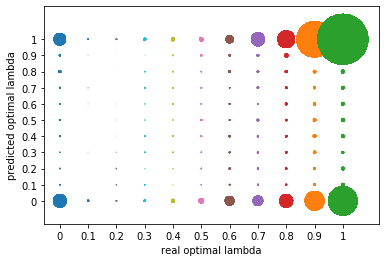

In [52]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

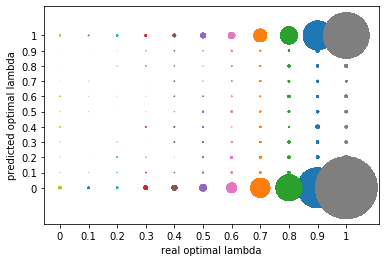

In [54]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

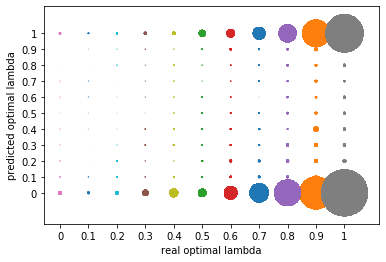

In [55]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

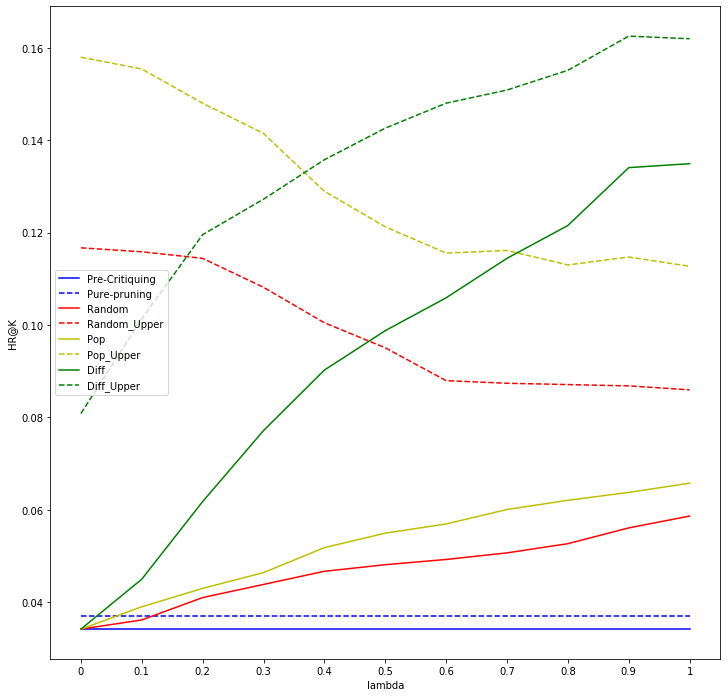

In [53]:
plot_lambda_vs_performance(df, k = 30, show = True, savefig = False)